<a href="https://colab.research.google.com/github/hrbolek/learning/blob/master/itsystems/neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN as predictor for signal value

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

#https://github.com/nerush/aind2-rnn/blob/master/RNN_project.ipynb
#https://www.youtube.com/watch?v=tPYj3fFJGjk

In [0]:
deltaTime = 0.01
windowSize = 10

## Preparation

### Pandas function

,0,1
0,0,0
1,1,1
2,2,4
3,3,9


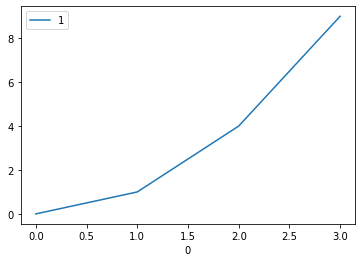

In [360]:
def plotSignal(data, x = 0, y = 1, ax = None):
  df = pd.DataFrame(data)
  #display(df)
  newax = None
  if ax is None:
    newax = df.plot.line(x = 0, y = y)
  else:
    newax = df.plot.line(x = 0, y = y, ax = ax)
  return newax

def displaySignal(data):
  df = pd.DataFrame(data)
  display(df)

#example of use
data = [(0, 0), (1, 1), (2, 4), (3, 9)]
plotSignal(data)
displaySignal(data)

### Function for connection of multiple state systems

$F(f_1, f_2, f_3, ..., f_n)(g)=f_n(...f_3(f_2(f_1(g))))$
```python
connect(f1, f2, f3)(g)
```
or
```python
f3(f2(f1(g)))
```

In [0]:
def connect(*F):
  def connected(g):
    result = g
    for f in F:
      result = f(result)
    return result
  return connected

### Time source system

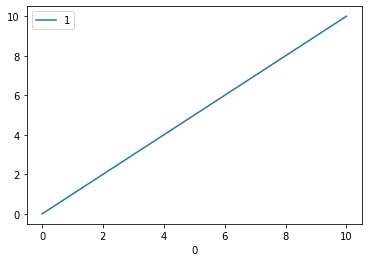

In [362]:
def createTimeGenerator(endTime, startTime = 0, deltaTime = 0.01):
  def time():
    currentTime = startTime
    while True:
      yield (currentTime, currentTime)
      currentTime = currentTime + deltaTime
      if currentTime > endTime:
        break
  return time

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)()
plotSignal(timeFunc)

### Step source system
This is not used in code

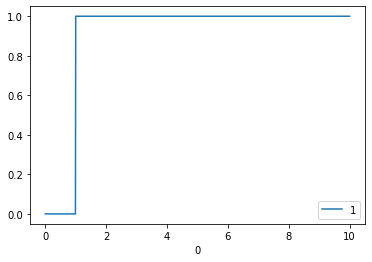

In [363]:
def createStep(stepTime):
  def u(gen):
    for (time, value) in gen:
      if (time < stepTime):
        yield (time, 0)
      else:
        yield (time, 1)
  return u

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
step = createStep(1)
plotSignal(step(timeFunc()))

### Just 1st order state system 

$\frac{Y(s)}{U(s)}=\frac{K}{Ts+1}$

$Y(s) \cdot (Ts+1)=U(s) \cdot K$

$Ty'(t)+y(t)=Ku(t)$

$y'(t)+\frac{1}{T}y(t)=\frac{K}{T}u(t)$

$y'(t)=\frac{K}{T}u(t)-\frac{1}{T}y(t)$

Euler:

$\lim\limits_{dt \to 0} \frac{y(t+dt)-y(t)}{dt} =\frac{K}{T}u(t)-\frac{1}{T}y(t)$

$\frac{y(t+dt)-y(t)}{dt} =\frac{K}{T}u(t)-\frac{1}{T}y(t)$

$y(t+dt)-y(t) =dt \left( \frac{K}{T}u(t)-\frac{1}{T}y(t) \right)$

$y(t+dt) =y(t) + dt \left( \frac{K}{T}u(t)-\frac{1}{T}y(t) \right)$

,0,1
0,0.00,0.000000
1,0.01,0.000000
2,0.02,0.000000
3,0.03,0.000000
4,0.04,0.000000
...,...,...
996,9.96,0.999878
997,9.97,0.999880
998,9.98,0.999881
999,9.99,0.999882


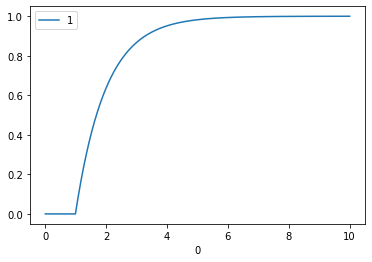

In [364]:
def createFilter1Order(K, T, deltaTime, y0 = 0):
  k1 = K / T
  k2 = 1 / T
  def filter(u):
    currentState = y0
    for time, value in u:
      result = currentState + deltaTime * (k1 * value - k2 * currentState)
      currentState = result
      yield (time, result)
  return filter

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
step = createStep(1)
system = createFilter1Order(1, 1, deltaTime)

simulation = connect(step, system)
plotSignal(simulation(timeFunc()))
displaySignal(simulation(timeFunc()))

### Just 2nd order system

$\frac{Y(s)}{U(s)}=\frac{Ts+1}{As^2+Bs+1}$

$Ay''(t)+By'(t)+y(t)=Tu'(t)+u(t)$

$Ay''(t)=Tu'(t)+u(t)-By'(t)-y(t)$

$Ay''(t)=Tu'(t)-By'(t)+u(t)-y(t)$

$y''(t)=\frac{T}{A}u'(t)-\frac{B}{A}y'(t)+\frac{1}{A}u(t)-\frac{1}{A}y(t)$

$y(t)=x_1(t)$

$x'_1(t)=\frac{T}{A}u(t)-\frac{B}{A}x_1(t) + x_2(t)$

$x'_2(t)=\frac{1}{A}u(t)-\frac{1}{A}x_1(t)$



,0,1
0,0.00,0.000000
1,0.01,0.000000
2,0.02,0.000000
3,0.03,0.000000
4,0.04,0.000000
...,...,...
996,9.96,1.006112
997,9.97,1.006184
998,9.98,1.006255
999,9.99,1.006324


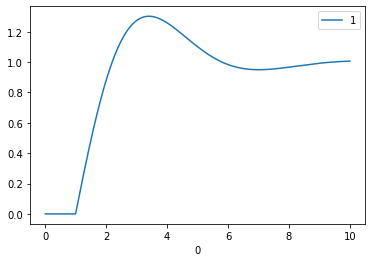

In [365]:
def createFilter2Order(T, A, B, deltaTime, x10 = 0, x20 = 0):
  def filter(u):
    x1 = x10
    x2 = x20
    for time, value in u:
      nx1 = x1 + deltaTime *((T / A) * value - B / A * x1 + x2)
      nx2 = x2 + deltaTime * ((1 / A) * value - 1 / A * x1)
      yield (time, nx1)
      x1 = nx1
      x2 = nx2
  return filter

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
step = createStep(1)
system = createFilter2Order(1, 1, 1, deltaTime)

simulation = connect(step, system)
plotSignal(simulation(timeFunc()))
displaySignal(simulation(timeFunc()))  

### Random signal source

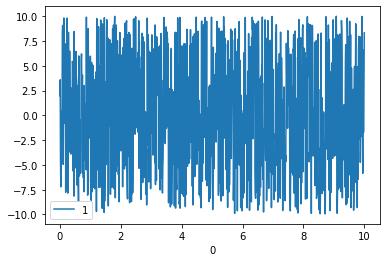

In [366]:
from random import random as rnd
from random import seed
def createRandomSignal(startValue = 0, stepValue = 10, timegen = []):
  currentValue = startValue
  for (time, value) in timegen:
    r = 2 * rnd() - 1
    yield time, stepValue * r

# example of use
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
rSignal = list(createRandomSignal(timegen = timeFunc()))
plotSignal(rSignal)
#displaySignal(rSignal(timeFunc()))

## Getting data for training
### Signal generation

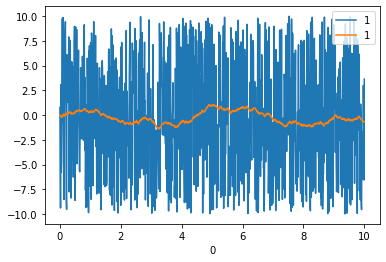

In [367]:
def filterSignal(signal, system):
  output = list(system(signal))
  return output

#example of use
seed(30) # important for deterministic results
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)

rSignal = list(createRandomSignal(timegen = timeFunc()))
system = createFilter2Order(1, 1, 1, 0.01)
fSignal = filterSignal(rSignal, system)

ax = plotSignal(rSignal)
ax = plotSignal(fSignal, ax = ax)

### Data transformation into training set

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
0,0.00,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.781631,-4.216071,-9.399262,3.072715,-5.799826,-4.854461,-2.056035,2.831563,9.776224,-0.769340,9.869700
1,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,-4.216071,-9.399262,3.072715,-5.799826,-4.854461,-2.056035,2.831563,9.776224,-0.769340,9.869700,9.851440
2,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,-9.399262,3.072715,-5.799826,-4.854461,-2.056035,2.831563,9.776224,-0.769340,9.869700,9.851440,-5.146489
3,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,3.072715,-5.799826,-4.854461,-2.056035,2.831563,9.776224,-0.769340,9.869700,9.851440,-5.146489,-8.547098
4,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.11,0.12,0.13,0.14,-5.799826,-4.854461,-2.056035,2.831563,9.776224,-0.769340,9.869700,9.851440,-5.146489,-8.547098,-6.801980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,9.86,9.87,9.88,9.89,9.90,9.91,9.92,9.93,9.94,9.95,9.96,-6.598268,-8.569755,1.113817,0.048165,-8.823545,-9.559863,-3.085507,-6.470056,-1.723456,-6.183016,-1.772242
987,9.87,9.88,9.89,9.90,9.91,9.92,9.93,9.94,9.95,9.96,9.97,-8.569755,1.113817,0.048165,-8.823545,-9.559863,-3.085507,-6.470056,-1.723456,-6.183016,-1.772242,2.999099
988,9.88,9.89,9.90,9.91,9.92,9.93,9.94,9.95,9.96,9.97,9.98,1.113817,0.048165,-8.823545,-9.559863,-3.085507,-6.470056,-1.723456,-6.183016,-1.772242,2.999099,-0.754096
989,9.89,9.90,9.91,9.92,9.93,9.94,9.95,9.96,9.97,9.98,9.99,0.048165,-8.823545,-9.559863,-3.085507,-6.470056,-1.723456,-6.183016,-1.772242,2.999099,-0.754096,-6.575507


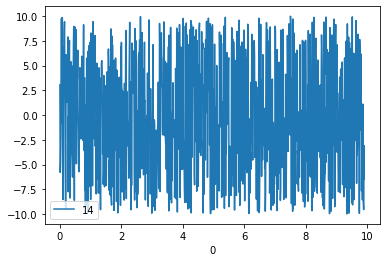

In [368]:
def createWindowFunc(windowSize = 10):
  def windowFunc(gen):
    bufferT = []
    bufferV = []
    for time, value in gen:
      if len(bufferT) == windowSize:
        yield (*bufferT, time, *bufferV, value)
      bufferT.append(time)
      bufferV.append(value)
      if len(bufferT) > windowSize:
        bufferT.pop(0)
        bufferV.pop(0)
  return windowFunc

# example of use  
windowFunc = createWindowFunc(windowSize = 10)
seed(30) # important for deterministic results
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
rSignal = list(createRandomSignal(timegen = timeFunc()))
windowedData = list(windowFunc(rSignal)) #list means store data permanently
displaySignal(windowedData)
plotSignal(windowedData, x = 0, y = 14)

In [369]:
def fromOutputToTrain(systemOutput, windowSize = 10):
  windowFunc = createWindowFunc(windowSize)
  windowOutput = windowFunc(systemOutput)
  windowOutputAsDataFrame = pd.DataFrame(windowOutput)
  #display(windowOutputAsDataFrame)
  fromIndex = windowSize + 1
  toIndex = 2 * windowSize + 1
  x_df = windowOutputAsDataFrame[range(fromIndex, toIndex)]
  y_df = windowOutputAsDataFrame[toIndex]
  y_train = y_df.to_numpy() 
  X_train = x_df.to_numpy()
  X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], windowSize, 1)))

  return (X_train, y_train)

# example of use  
seed(30) # important for deterministic results
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
rSignal = list(createRandomSignal(timegen = timeFunc()))
X, y = fromOutputToTrain(rSignal, windowSize = windowSize)
display(X[:3])
display(y[:3])
#plotSignal(windowedData, x = 0, y = 14)  

array([[[ 0.78163129],
        [-4.21607113],
        [-9.39926183],
        [ 3.07271508],
        [-5.79982609],
        [-4.8544605 ],
        [-2.05603475],
        [ 2.83156308],
        [ 9.77622421],
        [-0.7693398 ]],

       [[-4.21607113],
        [-9.39926183],
        [ 3.07271508],
        [-5.79982609],
        [-4.8544605 ],
        [-2.05603475],
        [ 2.83156308],
        [ 9.77622421],
        [-0.7693398 ],
        [ 9.86970015]],

       [[-9.39926183],
        [ 3.07271508],
        [-5.79982609],
        [-4.8544605 ],
        [-2.05603475],
        [ 2.83156308],
        [ 9.77622421],
        [-0.7693398 ],
        [ 9.86970015],
        [ 9.85143988]]])

array([ 9.86970015,  9.85143988, -5.14648929])

### Training RNN

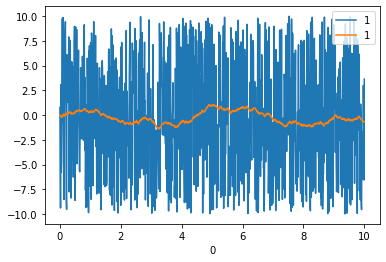

In [371]:
import numpy as np

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

def createNNModel(signalIn, signalOut, windowSize):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(units=5, input_shape=(windowSize, 1)))
    model.add(tf.keras.layers.Dense(units=1))
    
    optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=optimizer)

    Xin, yin = fromOutputToTrain(signalIn, windowSize = windowSize)
    Xout, yout = fromOutputToTrain(signalOut, windowSize = windowSize)
    model.fit(Xin, yout, epochs=1000, batch_size=50, verbose=0)
    return model

# example of use    
system = createFilter2Order(1, 1, 1, 0.01)

seed(30) # important for deterministic results
timeFunc = createTimeGenerator(startTime = 0, endTime = 10, deltaTime = 0.01)
signalIn = list(createRandomSignal(timegen = timeFunc()))
signalOut = list(system(signalIn))

ax = plotSignal(signalIn)
plotSignal(signalOut, ax = ax)
model = createNNModel(signalIn, signalOut, windowSize = windowSize)
display(model)

### RNN use

testing error = 0.4180832803249359


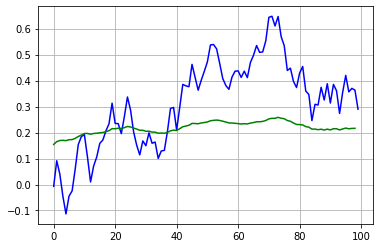

In [372]:
def calculateError(signal, predictedSignal):
  predictedSignalEx = predictedSignal.reshape(len(predictedSignal))
  err = predictedSignalEx[1:] - signal[:-1]
  return err

seed(30) # important for deterministic results
timeFunc = createTimeGenerator(startTime = 0, endTime = 20, deltaTime = 0.01)
signalIn = list(createRandomSignal(timegen = timeFunc()))
signalOut = list(system(signalIn))
X_testOut, y_testOut = fromOutputToTrain(signalOut, windowSize)
X_testIn, y_testIn = fromOutputToTrain(signalIn, windowSize)

testing_error = model.evaluate(X_testIn, y_testOut, verbose=0)
print('testing error = ' + str(testing_error))
test_predict = model.predict(X_test)
#err = calculateError(y_testOut, test_predict)

#display(test_predict)
#test_predict = test_predict.reshape(len(test_predict))
#err = test_predict[1:] - y_test[:-1]

#print(test_predict[:100])
#print(y_test[:10])
#print(err[:10])
plt.plot(y_testOut[:100], 'b-')
plt.plot(test_predict[1:100], 'g-')
#plt.plot(err[:100], 'r-')
plt.grid(which='both')
plt.show()


[(0.08, -0.0177054412237908, -0.0177054412237908), (0.09, -0.018531892, -0.01906706640904789), (0.09999999999999999, 0.0031051827, 0.0008630045591093392), (0.10999999999999999, 0.022117183, 0.02055725427986336), (0.11999999999999998, 0.013103477, 0.010058703160002454), (0.12999999999999998, -0.002106212, -0.007136079356743916), (0.13999999999999999, -0.015760686, -0.020668677673991758), (0.15, -0.0035182443, -0.006785881638093613)]
[(0.08, -0.0177054412237908), (0.09, -0.01906706640904789), (0.09999999999999999, 0.0008630045591093392), (0.10999999999999999, 0.02055725427986336), (0.11999999999999998, 0.010058703160002454), (0.12999999999999998, -0.007136079356743916), (0.13999999999999999, -0.020668677673991758), (0.15, -0.006785881638093613)]


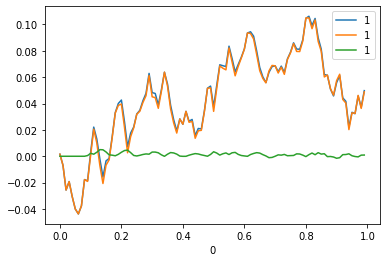

In [282]:
def calculateError2(signal, predictedSignal):
  signalEx = np.array(list(map(lambda item: item[1], signal)))
  time = list(map(lambda item: item[0], signal))
  predictedSignalEx = np.array(list(map(lambda item: item[1], predictedSignal)))

  #err = predictedSignalEx[1:] - signalEx[:-1]
  err = predictedSignalEx - signalEx
  result = zip(time, err)
  return result

# for some reason this is quite slow
def createFortuneTeller(model, windowSize):
  def fortuneTeller(g):
    buffer = []
    newValue = None
    for time, value in g:
      buffer.append([value])
      if len(buffer) == windowSize:
        newValue = model.predict([buffer])

      if newValue is None:
        yield time, value, value
      else:
        yield time, newValue[0][0], value

      if len(buffer) == windowSize:
        newValue = model.predict([buffer])
        buffer.pop(0)

  return fortuneTeller
  
seed(30) # important for deterministic results
randomSignalExtended = list(createFilteredRandomSignal(1)) #list means store data permanently
predictiveSystem = createFortuneTeller(model = model, windowSize = 10)
predictedSignal = list(predictiveSystem(randomSignalExtended))
print(predictedSignal[8:16])
print(randomSignalExtended[8:16])
err = calculateError2(randomSignalExtended, predictedSignal)
ax = plotSignal(predictedSignal)
ax = plotSignal(randomSignalExtended, ax = ax)
ax = plotSignal(err, ax = ax)
#displaySignal(predictedSignal)


10 [[0.00285610378759654], [-1.6895063274840506e-05], [0.0031069259327367233], [-0.008680214041010575], [0.003939438153692331], [0.016843598673493228], [0.022814064042805324], [0.008995105663130056], [0.009731928992095738], [0.002745522167058506]]
10 [[0.00285610378759654], [-1.6895063274840506e-05], [0.0031069259327367233], [-0.008680214041010575], [0.003939438153692331], [0.016843598673493228], [0.022814064042805324], [0.008995105663130056], [0.009731928992095738], [0.002745522167058506]]
0 []
10 [[-1.6895063274840506e-05], [0.0031069259327367233], [-0.008680214041010575], [0.003939438153692331], [0.016843598673493228], [0.022814064042805324], [0.008995105663130056], [0.009731928992095738], [0.002745522167058506], [-0.007282065987156064]]
10 [[-1.6895063274840506e-05], [0.0031069259327367233], [-0.008680214041010575], [0.003939438153692331], [0.016843598673493228], [0.022814064042805324], [0.008995105663130056], [0.009731928992095738], [0.002745522167058506], [-0.007282065987156064]]

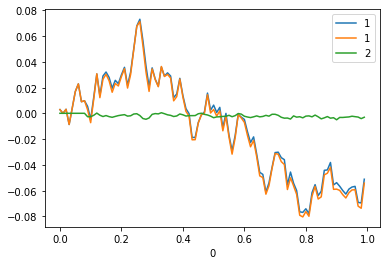

In [325]:
def createFortuneTellerPlus(model, windowSize, memorySize = 2):
  def fortuneTeller(g):
    buffer = []
    newValues = []
    newValue = None
    error = 0
    for time, value in g:

      buffer.append([value])
      if len(buffer) == windowSize:
        dataFeed = [*buffer]
        if (len(newValues) == memorySize):
          #error = value - new
          dataFeed = [*buffer[:windowSize - memorySize - 1], *newValues[-memorySize:], buffer[-1]]
          #!!!!dataFeed[-2] = [newValue]!!!

        #"""
        print(len(buffer), buffer)
        print(len(dataFeed), dataFeed)
        print(len(newValues), newValues)
        #"""

        newValue = model.predict([dataFeed])[0][0]
        newValues.append([newValue])
        if (len(newValues) > memorySize):
          newValues.pop(0)

      if newValue is None:
        yield time, value, 0
      else:
        yield time, newValue, value - newValue


      if len(buffer) == windowSize:
        #newValue = model.predict([buffer])
        buffer.pop(0)
  return fortuneTeller
  
seed(10) # important for deterministic results
randomSignalExtended = list(createFilteredRandomSignal(1)) #list means store data permanently
predictiveSystem = createFortuneTellerPlus(model = model, windowSize = 10, memorySize = 8)
predictedSignal = list(predictiveSystem(randomSignalExtended))
err = calculateError2(randomSignalExtended, predictedSignal)
ax = plotSignal(predictedSignal)
plotSignal(randomSignalExtended, ax = ax)
plotSignal(predictedSignal, x = 0, y = 2, ax = ax)
#displaySignal(predictedSignal)

training error = 3.6195986467646435e-05
3000 2990
testing error = 3.643751551862806e-05


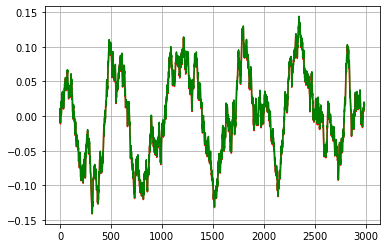

In [104]:
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

def fromOutputToTrain(systemOutput, windowSize = 10):
  windowFunc = createWindowFunc(windowSize)
  windowOutput = windowFunc(systemOutput)
  windowOutputAsDataFrame = pd.DataFrame(windowOutput)
  #display(windowOutputAsDataFrame)
  fromIndex = windowSize + 1
  toIndex = 2 * windowSize + 1
  x_df = windowOutputAsDataFrame[range(fromIndex, toIndex)]
  y_df = windowOutputAsDataFrame[toIndex]
  y_train = y_df.to_numpy() 
  X_train = x_df.to_numpy()
  X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], windowSize, 1)))

  return (X_train, y_train)

X_train, y_train = fromOutputToTrain(output2, windowSize)

#display(y_train)
#display(X_train)

system3 = connect(
#    system,
    createRandomSignal(10, 1),
    createFilter2Order(1, 1, 1, deltaTime = deltaTime)
)
timeFunc = createTimeGenerator(startTime = 0, deltaTime = deltaTime, endTime = 30)
seed(30)
output3 = list(system3(timeFunc()))
X_test, y_test = fromOutputToTrain(output3, windowSize)


print(len(output3),len(X_test))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

test_predict = model.predict(X_test)
#display(test_predict)
plt.plot(y_test, 'r-')
plt.plot(test_predict, 'g-')
plt.grid(which='both')
#pd.DataFrame(output3)#.tail()